Note: this competition was drastically affected by a data leak. We will not be utilizing this leak here, so our results aren't going to be in the same stratosphere as those in the top half of the leaderboard.

In [2]:
import numpy as np
import pandas as pd
import math as mt
import csv as csv

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn import preprocessing

import xgboost as xgb
from xgboost import plot_importance

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [4]:
#Size of train dataframe. 4459 rows, 4993 columns (1 ID, 1 response, 4991 predictors)
train.shape

(4459, 4993)

In [5]:
#Size of test dataframe. 49342 rows, 4992 columns (1 ID, 4991 predictors)
test.shape

(49342, 4992)

In [6]:
train.head(n=10)

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,11d86fa6a,77c9823f2,8d6c2a0b2,4681de4fd,adf119b9a,cff75dd09,96f83a237,b8a716ebf,6c7a4567c,4fcfd2b4d,f3b9c0b95,71cebf11c,d966ac62c,68b647452,c88d108c9,ff7b471cd,d5308d8bc,0d866c3d7,bc3f77679,bd8f989f1,0eff5bf95,22ed6dba3,92b13ebba,c330f1a67,233c7c17c,2cb4d123e,eeac16933,87ffda550,...,969caa87a,00302fe51,1189ee335,ca04a07ca,f6f15ffa5,841704460,ea5ed6ff7,b1bb8eac3,8132d18b8,c24ea6548,cdfc2b069,2a879b4f7,6b119d8ce,98dea9e42,9f2471031,88458cb21,f40da20f4,7ad6b38bd,c901e7df1,8f55955dc,85dcc913d,5ca0b9b0c,eab8abf7a,8d8bffbae,2a1f6c7f9,9437d8b64,5831f4c76,2e84e09c5,d45fd5508,a165f5761,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0,0,1300000.0,...,0,0,1100000.0,0,0,0,0.0,0.0,14800000,0.0,1200000.0,0.0,0.0,0,0,0,0,0.0,4000000,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,2200000.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,2000000.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
5,002dbeb22,2800000.0,0.0,0,0.0,0,0,0,0,0,17020000.0,0.0,8000.0,0,0,0,0,0.0,0,5000000.0,0,0,0.0,0,0,0.0,0,0,0,12000.0,0,4600.0,12000,8891333.34,0.0,0,0.0,0,0,0.0,...,12000,0,0.0,0,0,0,0.0,0.0,0,0.0,20000000.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,12000.0,5600000.0,20000000.0,0,0,0,0,0,0,11000
6,003925ac6,164000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,40000,0,0,0
7,003eb0261,600000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
8,004b92275,979000.0,0.0,0,0.0,0,0,0,0,0,58000.0,0.0,0.0,0,0,22000,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,4000000.0,0.0,16000.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,22000,0.0,0.0,0.0,4000000.0,0,0,0,0,0,0,0
9,0067b4fef,460000.0,0.0,0,0.0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0,0.00,0.0,0,0.0,0,0,0.0,...,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,400000


In [7]:
#Break training data into response and predictors.
y = train['target']

X = train.copy()
X.drop(['ID', 'target'], axis=1, inplace=True)

#Prepare test dataframe for ML algorithms
X_test = test.copy()
X_test.drop(['ID'], axis=1, inplace=True)

#New predictors measuring sum of entries for each row, and number of nonzero entries for each row.
X['sum'] = X.sum(axis=1)
X_test['sum'] = X_test.sum(axis=1)

X['nonzero'] = X[X==0].isnull().sum(axis=1)
X_test['nonzero'] = X_test[X_test==0].isnull().sum(axis=1)

#Remove columns (256 total) that contain no information (i.e., entries in train DF sum to zero)
sums = X.sum()
zero_cols = sums[sums == 0].index

X.drop(zero_cols, axis=1, inplace=True)
X_test.drop(zero_cols, axis=1, inplace=True)

In [8]:
#pairwise correlations between predictors
corr = X.corr()

#use training data to determine which columns are highly correlated
high_corr_cols = []

for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if corr.iloc[i,j] > .9 and not(corr.columns[i] in high_corr_cols) and not(corr.columns[j] in high_corr_cols):
            #print(i,j,': ', corr.iloc[i,j])
            high_corr_cols.append(corr.columns[j])

            
#Get rid of highly correlated predictors
X.drop(high_corr_cols, axis=1, inplace=True)
X_test.drop(high_corr_cols, axis=1, inplace=True)

In [9]:
#We are now down to 4484 predictors
X.shape

(4459, 4484)

The evaluation metric for this competition is Root Mean Squared Logarithmic Error. The RMSLE is calculated as

$\varepsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\ln(p_i+1) \text{ - } \ln(a_i+1))^2}$

Where:
1. ϵ is the RMSLE value (score)
1. n is the total number of observations in the data set,
1. $p_i$ is your prediction of target for the ith observation, and
1. $a_i$ is the actual target for the ith observation. 

In [10]:
#Setting up the evaluation metric. Will be used when training models to quantify model fit.
class RMSLE:
    def __init__(self):
        pass
    
    def _RMSLE(self, y_pred, y_actual):
        y_pred = np.array(y_pred)
        y_actual = np.array(y_actual)
        return mt.sqrt((1/len(y_pred))*np.sum(np.square(np.log1p(y_pred) - np.log1p(y_actual))))
    
    def RMSLE_xgb(self, y_pred, dtrain):
        labels = dtrain.get_label()
        RMSLE_score = self._RMSLE(y_pred, labels)
        return [('RMSLE', RMSLE_score)]

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=2)
eval_set = [(X_val, y_val)]

Below we fit an XGBoost model to our training data with some generic boosting parameters, which will be fine-tuned later. The below boosting process is intended to find a good number of boosting rounds to perform, stopping when we stop noticing an increase in the validation RMSLE.

In [12]:
xgb1 = xgb.XGBRegressor(
 learning_rate = 0.05,
 n_estimators=50,
 max_depth=10,
 min_child_weight=1,
 subsample=1,
 colsample_bytree=1,
 seed=1)

eval_metric = RMSLE()

xgb1.fit(X_train, y_train, 
         early_stopping_rounds = 5, 
         eval_set = eval_set, 
         eval_metric=eval_metric.RMSLE_xgb, 
         verbose=False)

print("Optimal boosting rounds: {} \nRMSLE Score: {}".format(xgb1.get_booster().best_ntree_limit, xgb1.get_booster().best_score))

Optimal boosting rounds: 11 
RMSLE Score: 1.522158


Next, we set the number of boosting rounds ('n_estimators') to 11 and use 5-fold cross-validation to fine-tune our boosting parameters in order of decreasing importance. First we tune the max_depth and min_child_weight of our boosting trees. Then we tune the subsample and colsample_bytree parameters. The purported optimal values are in the code below, and the values that were tested are commented out to their right.

In [13]:
param_grid = {
    'learning_rate': [.05],
    'n_estimators': [11],
    'max_depth': [10],             #tested [4,,6,8,9,10,11,12]
    'min_child_weight': [7],      #tested [1,2,3,4,5,6,7,8,9]
    'subsample': [1],       #tested [.4,.6,.8,.9,.95,1]
    'colsample_bytree': [1],    #tested [.4,.6,.8,.9,.95,1]
}

xgb_reg = xgb.XGBRegressor(random_state=1)

cv_xgb = GridSearchCV(estimator = xgb_reg, param_grid = param_grid, n_jobs = -1, cv = 5, scoring=make_scorer(eval_metric._RMSLE, greater_is_better = False))
cv_xgb.fit(X_train,y_train)

best_xgb = cv_xgb.best_estimator_
print(cv_xgb.best_score_, cv_xgb.best_params_)

-1.5250448506581809 {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 7, 'n_estimators': 11, 'subsample': 1}


Next we keep the optimal parameters, lower the learning rate, and find the number of boosting rounds that works best with this new, lower learning rate.

In [14]:
xgb1 = xgb.XGBRegressor(
 learning_rate = 0.01,
 n_estimators=200,
 max_depth=10,
 min_child_weight=7,
 subsample=1,
 colsample_bytree=1,
 seed=1)

xgb1.fit(X_train, y_train, 
         early_stopping_rounds = 10, 
         eval_set = eval_set, 
         eval_metric=eval_metric.RMSLE_xgb, 
         verbose=False)

print("Optimal boosting rounds: {} \nRMSLE Score: {}".format(xgb1.get_booster().best_ntree_limit, xgb1.get_booster().best_score))

Optimal boosting rounds: 63 
RMSLE Score: 1.494098


Finally, let's see what sort of test error we can get with an XGBoost model with these parameters. We'll retrain on the entire training set.

In [15]:
xgb_final = xgb.XGBRegressor(
 learning_rate = 0.01,
 n_estimators=63,
 max_depth=10,
 min_child_weight=7,
 subsample=1,
 colsample_bytree=1,
 seed=1)

xgb_final.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=10,
       min_child_weight=7, missing=None, n_estimators=63, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1, silent=True, subsample=1)

In [16]:
xgb_test_preds = pd.Series(xgb_final.predict(X_test))

xgb_test_preds_df = pd.concat([test['ID'], xgb_test_preds], axis=1)
xgb_test_preds_df.rename(columns={0:'target'}, inplace=True)

xgb_test_preds_df.to_csv('xgb_submission.csv', index=False, quoting=csv.QUOTE_NONNUMERIC) #test RMSLE = 1.54927

**DIMENSION REDUCTION VIA PRINCIPAL COMPONENTS ANALYSIS**

In [17]:
scaler = preprocessing.StandardScaler()
scaler.fit(X)

X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

X_scaled.head(n=10)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,dc5a8f1d8,11d86fa6a,77c9823f2,8d6c2a0b2,4681de4fd,adf119b9a,cff75dd09,96f83a237,b8a716ebf,6c7a4567c,4fcfd2b4d,f3b9c0b95,71cebf11c,d966ac62c,68b647452,c88d108c9,ff7b471cd,0d866c3d7,bc3f77679,bd8f989f1,0eff5bf95,22ed6dba3,92b13ebba,233c7c17c,2cb4d123e,87ffda550,822e49b95,316b978cd,d04e16aed,5d5c5ce6d,ec863cb52,...,ab7764ead,a380d5301,46ee7f2c8,2e1287e41,23310aa6f,969caa87a,00302fe51,1189ee335,ca04a07ca,841704460,ea5ed6ff7,b1bb8eac3,8132d18b8,c24ea6548,cdfc2b069,2a879b4f7,6b119d8ce,9f2471031,88458cb21,7ad6b38bd,c901e7df1,8f55955dc,85dcc913d,eab8abf7a,8d8bffbae,2a1f6c7f9,9437d8b64,5831f4c76,d45fd5508,a165f5761,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,fb36b89d9,7e293fbaf,9fc776466,sum,nonzero
0,-0.037646,-0.021639,-0.04689,-0.019205,-0.017437,-0.053221,-0.022451,-0.024846,-0.267393,-0.097765,-0.081369,-0.014977,-0.028876,-0.145479,-0.088577,-0.056368,-0.032868,-0.122579,-0.050539,-0.06967,-0.070391,-0.028072,-0.063838,-0.097167,-0.0418,-0.02571,-0.106546,-0.024702,-0.195458,-0.026732,-0.190989,-0.131103,-0.109261,-0.09053,0.006855,-0.147928,-0.064203,-0.134258,-0.060813,-0.034537,...,-0.052139,-0.021639,-0.064536,-0.097033,-0.269411,-0.016098,-0.048588,0.06917,-0.078241,-0.068648,-0.154269,-0.131145,1.897559,-0.127742,0.098504,-0.109831,-0.136631,-0.014977,-0.035221,-0.086555,0.310269,-0.036796,-0.062993,-0.108148,-0.117917,-0.057864,-0.103842,-0.181415,-0.029019,-0.096534,-0.114959,-0.100403,-0.178522,-0.114247,-0.014977,-0.072342,-0.056363,-0.125852,-0.277592,-0.259407
1,-0.037646,-0.021639,-0.04689,-0.019205,-0.017437,-0.053221,-0.022451,-0.024846,-0.038443,-0.097765,-0.081369,-0.014977,-0.028876,-0.145479,-0.088577,-0.056368,-0.032868,-0.122579,-0.050539,-0.06967,-0.070391,-0.028072,-0.063838,-0.097167,-0.0418,-0.02571,-0.106546,-0.024702,-0.195458,-0.026732,-0.190989,-0.131103,-0.109261,-0.09053,-0.169767,-0.147928,-0.064203,-0.134258,-0.060813,-0.034537,...,-0.052139,-0.021639,-0.064536,-0.097033,-0.269411,-0.016098,-0.048588,-0.10653,-0.078241,-0.068648,-0.154269,-0.131145,-0.090717,-0.127742,-0.181402,-0.109831,-0.136631,-0.014977,-0.035221,-0.086555,-0.100021,-0.036796,-0.062993,-0.108148,-0.117917,-0.057864,-0.103842,-0.181415,-0.029019,-0.096534,-0.114959,-0.100403,-0.178522,-0.114247,-0.014977,-0.072342,-0.056363,-0.125852,-0.356072,-0.424453
2,-0.037646,-0.021639,-0.04689,-0.019205,-0.017437,-0.053221,-0.022451,-0.024846,-0.267393,-0.097765,-0.081369,-0.014977,-0.028876,-0.145479,-0.088577,-0.056368,-0.032868,-0.122579,-0.050539,-0.06967,-0.070391,-0.028072,-0.063838,-0.097167,-0.0418,-0.02571,-0.106546,-0.024702,-0.195458,-0.026732,-0.190989,-0.131103,-0.109261,-0.09053,-0.169767,-0.147928,-0.064203,-0.134258,-0.060813,-0.034537,...,-0.052139,-0.021639,-0.064536,-0.097033,-0.269411,-0.016098,-0.048588,-0.10653,-0.078241,-0.068648,-0.154269,-0.131145,-0.090717,-0.127742,-0.181402,-0.109831,-0.136631,-0.014977,-0.035221,-0.086555,-0.100021,-0.036796,-0.062993,-0.108148,-0.117917,-0.057864,-0.103842,-0.181415,-0.029019,-0.096534,-0.114959,-0.100403,-0.178522,-0.114247,-0.014977,-0.072342,-0.056363,-0.125852,-0.545523,-0.655518
3,-0.037646,-0.021639,-0.04689,-0.019205,-0.017437,-0.053221,-0.022451,-0.024846,-0.267393,-0.097765,-0.081369,-0.014977,-0.028876,-0.145479,-0.088577,-0.056368,-0.032868,-0.122579,-0.050539,-0.06967,-0.070391,-0.028072,-0.063838,-0.097167,-0.0418,-0.02571,-0.106546,-0.024702,-0.195458,-0.026732,-0.190989,-0.131103,-0.109261,-0.09053,-0.169767,-0.147928,-0.064203,-0.134258,-0.060813,-0.034537,...,-0.052139,-0.021639,-0.064536,-0.097033,-0.269411,-0.016098,-0.048588,-0.10653,-0.078241,-0.068648,-0.154269,-0.131145,-0.090717,-0.127742,-0.181402,-0.109831,-0.136631,-0.014977,-0.035221,-0.086555,-0.100021,-0.036796,-0.062993,-0.108148,-0.117917,-0.057864,-0.103842,-0.181415,-0.029019,-0.096534,-0.114959,-0.100403,-0.178522,-0.114247,-0.014977,-0.072342,-0.056363,-0.125852,-0.563318,-0.636656
4,-0.037646,

In [18]:
pca = PCA(n_components=1500)
pca.fit(X_scaled)
print(pca.explained_variance_ratio_.sum())

X_pca = pca.transform(X_scaled)

0.9441534442620314


In [19]:
#evr_cum[i] will contain the ratio of variance explained by the first i principal components
evr_cum = [0]
for i,num in enumerate(pca.explained_variance_ratio_):
    evr_cum.append(evr_cum[i] + pca.explained_variance_ratio_[i])

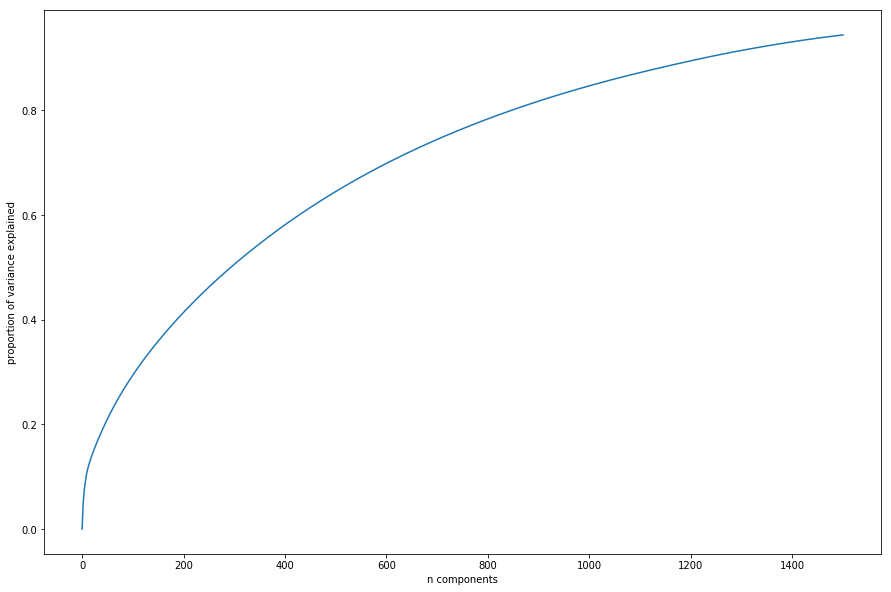

In [20]:
f, ax = plt.subplots(figsize=(15, 10))
plt.plot(evr_cum)
plt.xlabel("n components")
plt.ylabel("proportion of variance explained")
plt.show()

This graph shows that none of the PC's capture much of the variation in the data, and it takes a huge number of them to capture a high proportion of the data's variance. As such, our PC's are basically as noisy as the original data, so PCA doesn't seem like a great option for dimensionality reduction in this case. 

**Linear Regression**

Pretty much any type of linear regression (on the original dataset, or the principal components) is also off the table because it will likely spit out some negative predictions. Negative predictions (1) won't make sense in the context of our problem, and (2) won't jive with our evaluation metric since RMSLE can only be evaluated when all predictions are > -1, and will only produce non-garbage when all predictions are >= 0.

In [21]:
X_pca_train, X_pca_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.3, random_state=2)
eval_set = [(X_pca_val, y_val)]

reg = LinearRegression()
reg.fit(X_pca_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [22]:
#No fixes for negative predictions results in error
lr_preds = reg.predict(X_pca_val)
RMSLE()._RMSLE(lr_preds, y_val)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log1p
  if __name__ == '__main__':


nan

In [23]:
#Replace predictions with their absolute value
lr_preds = reg.predict(X_pca_val)
lr_preds = abs(lr_preds)
RMSLE()._RMSLE(lr_preds, y_val)

2.473138228376897

In [24]:
#Replace negative predictions with 0
lr_preds = reg.predict(X_pca_val)
lr_preds[lr_preds< 0] = 0
RMSLE()._RMSLE(lr_preds, y_val)

7.287510455798473

Yep, linear/lasso regression won't work well here as there are many negative predictions. Easy "fixes" such as replacing predictions with their absolute value yields a really bad validation RMSLE of ~2.473, and replacing negative predictions with 0 produces an abysmal ~7.288 validation RMSLE.